# OCR with vision-language models with vLLM

This notebook provides a step-by-step guide to building an OCR system
using vision-language models with vLLM and Gradio for inference.
 
Optical Character Recognition (OCR) is essential for extracting text from images, scanned documents, and handwritten content.
Vision-language models (VLMs) enhance OCR by leveraging transformer-based architectures, enabling context-aware text recognition.
 
This tutorial explores how to use models like LLaVA, BLIP-2, and Qwen-VL for OCR. It covers the following topics:

[Installing dependencies](#install-deps)  
[Building an OCR with vLLM](#cli-ocr)  
[Transforming the OCR to a GUI-enabled system with multiple model choices](#gradio-gui)


The tutorial uses vLLM for large language model (LLM) inference. vLLM optimizes text generation workloads by effectively batching requests and utilizing GPU resources, offering high throughput and low latency, which is perfect for chatbots.

![OCR Example](./assets/ocr.gif)
---

## Prerequisites

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access the [Meta Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B).

<a id="install-deps"></a>
## 1. Installing dependencies

Install the libraries needed for this tutorial. Run the following commands inside the Jupyter notebook running within the Docker container:

In [1]:
!pip install gradio requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 MB 80.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 141.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hubm━━━━━━━━━━━━━━━━━━━━━━━━━━  4/12 [ruff]
    Found existing installation: huggingface-hub 0.33.1━━━━━━━  4/12 [ruff]
    Uninstalling huggingface-hub-0.33.1:━━━━━━━━━━━━━━━━━━━━━━  4/12 [ruff]
      Successfully uninstalled huggingface-hub-0.33.1━━━━━━━━━━━━━  8/12 [huggingface-hub]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [gradio]11/12 [gradio]face-hub]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


### Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1-8B. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.2-11B-Vision-Instruct](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision-Instruct). Tokens typically start with "hf_".

Run the following interactive block in your Jupyter notebook to set up the token:

In [2]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


Verify that your token was accepted correctly:

In [3]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")


Token validated successfully! Logged in as: Chamath


<a id="cli-ocr"></a>
## 2. Building an OCR with vLLM

First, define the `ImageInference` inference class. This class provides a constructor to initialize a model for inference. Additionally, it defines another function that runs inference on an image that you provide. 

In [22]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from PIL import Image
from vllm.multimodal.utils import fetch_image
import sys

current_model = "meta-llama/Llama-3.2-11B-Vision-Instruct"

class ImageInference:
    def __init__(self, model_name=current_model):
        # Initialize the model and tokenizer
        self.llm = LLM(model=model_name, max_model_len=4096, max_num_seqs=16, enforce_eager=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def generate_image_output(self, image: Image) -> str:
        # Prepare the prompt and the image for the model
        messages_og = [{'role': 'user', 'content': "<|image|> What is in this image?"}]
        messages = [{
            'role': 'user',
            'content': (
                "Act as an OCR assistant. Analyze the provided <|image|> image and:\n"
                "1. Identify and transcribe all visible text in the image exactly as it appears.\n"
                "2. Preserve the original line breaks, spacing, and formatting from the image.\n"
                "3. Output only the transcribed text, line by line, without adding any commentary or explanations or special characters.\n"
            )
        }]
        prompt = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        sampling_params = SamplingParams(max_tokens=512, temperature=0.7)

        # Generate output from the model
        outputs = self.llm.generate({
            "prompt": prompt,
            "multi_modal_data": {"image": image},
        }, sampling_params=sampling_params)

        # Extract and return generated text
        generated_text = outputs[0].outputs[0].text if outputs else "No output generated."
        return generated_text


### Testing the OCR system
Download [this test image](https://github.com/ROCm/gpuaidev/tree/main/docs/notebooks/assets/together_we_advance_.png) by running the following command:

In [5]:
import requests

url = "https://raw.githubusercontent.com/ROCm/gpuaidev/main/docs/notebooks/assets/together_we_advance_.png"
filename = "together_we_advance_.png"

response = requests.get(url)
with open(filename, "wb") as file:
    file.write(response.content)

print("Download complete:", filename)

Download complete: together_we_advance_.png



Now it's time to test your OCR system. First read the image, then view it.

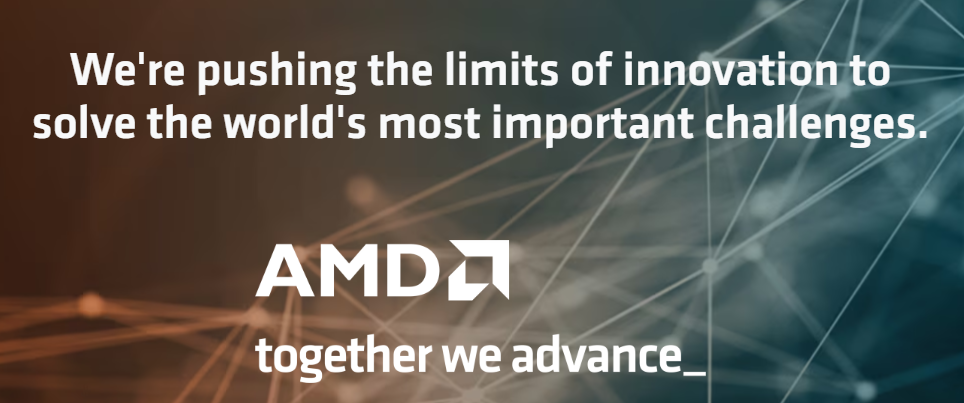

In [6]:
pil_image = Image.open("together_we_advance_.png")
pil_image = pil_image.convert("RGB")  # Ensure the image is in RGB format
pil_image

Next, initialize an instance of the `ImageInference` class. 

In [ ]:
# Initialize the inference class
inference = ImageInference()

Now pass the image to the model for inference and print the results.

In [ ]:

# Generate output for the image
output = inference.generate_image_output(pil_image)

# Print the result
print("Model Output:")
print(output)

Congratulations. You've just built an OCR system. That's how simple it is to create an OCR-like system that transcribes the text in a given image. 

<a id="gradio-gui"></a>
## 3. Transforming the OCR to a GUI-enabled system with multiple model choices

To provide a graphical interface for your chatbot, use [Gradio](https://www.gradio.app/) to create an interactive web-based UI.

### Import Gradio and define a list of VLM models to access 

You're going to create a shortlist of handpicked models that can analyze images. The full list is available [here](https://docs.vllm.ai/en/latest/models/supported_models.html). 



In [8]:
import gradio as gr

# Define available models and their Hugging Face model IDs
MODEL_OPTIONS = {
    "Llama-3.2-11B-Vision-Instruct": "meta-llama/Llama-3.2-11B-Vision-Instruct",
    "BLIP-2 (2.7B)": "Salesforce/blip2-opt-2.7b",
    "BLIP-2 (6.7B)": "Salesforce/blip2-opt-6.7b",
    "Fuyu (8B)": "adept/fuyu-8b",
    "GLM-4V (9B)": "THUDM/glm-4v-9b",
    "H2OVL Mississippi (2B)": "h2oai/h2ovl-mississippi-2b",
    "H2OVL Mississippi (800M)": "h2oai/h2ovl-mississippi-800m",
    "InternVL2 (4B)": "OpenGVLab/InternVL2-4B",
    "InternVL2 (2B)": "OpenGVLab/Mono-InternVL-2B",
    "LLaVA 1.5 (7B)": "llava-hf/llava-1.5-7b-hf",
    "LLaVA 1.5 (13B)": "llava-hf/llava-1.5-13b-hf",
    "MiniCPM-V (2_5)": "openbmb/MiniCPM-Llama3-V-2_5",
    "MiniCPM-V (2)": "openbmb/MiniCPM-V-2",
    "Molmo (7B)": "allenai/Molmo-7B-D-0924",
    "PaliGemma (3B PT)": "google/paligemma-3b-pt-224",
    "PaliGemma (3B Mix)": "google/paligemma-3b-mix-224",
    "Phi-3 Vision (128K)": "microsoft/Phi-3-vision-128k-instruct",
    "Phi-3.5 Vision": "microsoft/Phi-3.5-vision-instruct",
    "Pixtral (12B)": "mistralai/Pixtral-12B-2409",
    "Qwen-VL": "Qwen/Qwen-VL",
    "Qwen-VL-Chat": "Qwen/Qwen-VL-Chat",
    "Qwen2-VL (2B)": "Qwen/Qwen2-VL-2B-Instruct",
    "Qwen2-VL (7B)": "Qwen/Qwen2-VL-7B-Instruct",
}

### Create the Gradio interface

Next, define two simple helper functions for switching models and running inference using your previously defined class, followed by Gradio blocks:

In [9]:
def switch_model(model_name):
    global inference
    try:
        inference = ImageInference(model_name=model_name)
        return f"Switched to model: {model_name}"
    except Exception as e:
        return f"Failed to switch model: {str(e)}"

def analyze_image(image):
    try:
        pil_image = image.convert("RGB")
        result = inference.generate_image_output(pil_image)
        return result
    except Exception as e:
        return f"Error processing the image: {str(e)}"

with gr.Blocks() as interface:
    gr.Markdown("## Multimodal OCR & Image Analysis")
    
    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=list(MODEL_OPTIONS.keys()),
            value="Llama-3.2-11B-Vision-Instruct",
            label="Select Model",
        )
        switch_button = gr.Button("Switch Model")

    model_status = gr.Textbox(value=f"Current Model: {current_model}", label="Model Status")

    image_input = gr.Image(type="pil", label="Upload Image")
    analyze_button = gr.Button("Analyze Image")
    # output_box = gr.Textbox(label="Model Output", lines=10)
    output_box = gr.Markdown(label="Model Output")

    switch_button.click(
        fn=lambda selected_model: (switch_model(MODEL_OPTIONS[selected_model]), f"Current Model: {MODEL_OPTIONS[selected_model]}"),
        inputs=[model_dropdown],
        outputs=[model_status, model_status],
    )
    analyze_button.click(fn=analyze_image, inputs=image_input, outputs=output_box)


### Run the Gradio application

Execute the code block below to launch the GUI. The interface displays in your browser, letting you interact with the OCR system.

In [10]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7b382a9e84ae69d512.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


config.json:   0%|          | 0.00/987 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

INFO 08-01 19:53:46 [config.py:853] This model supports multiple tasks: {'classify', 'embed', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
INFO 08-01 19:53:46 [config.py:3345] Downcasting torch.float32 to torch.bfloat16.


tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]


## Conclusion

In this tutorial, you accomplished the following tasks:

* Built an OCR class using vLLM.
* Extended the functionality by adding a GUI and a selection of multiple different models.

Happy coding! If you encounter issues or have questions, don’t hesitate to ask or raise an issue on our [Github page](https://github.com/ROCm/gpuaidev)!